# Creating ```AngularCatalog```s and ```ImageMask```s

Py2PAC has several ways to create ```AngularCatalog```s and ```ImageMask```s.  We'll start with ```ImageMask```s since we need them in order to do anything meaningful with an ```AngularCatalog```.

First, import the things that we'll need.

In [2]:
import AngularCatalog_class as ac
import ImageMask_class as imclass

import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6)

--------

## Ways to create an ```ImageMask```

There are three main ways to create an ```ImageMask``` in Py2PAC, all ```classmethod```s of ```ImageMask```:

1. ```from_ranges```: Creates a rectangular image mask over a range in RA and Dec with equal completeness in all parts of the image.  **Bug to be fixed: doesn't allow for negative RAs**
1. ```from_array```: **This doesn't work the way it should at the moment because WCS is wonky.**  This creates a rectangular image mask with the completeness in each cell defined by the value of an input array.  I show here how it currently malfunctions.  Eventually, this should be fixed.
1. ```from_FITS_weight_file```: Reads in a weight map in FITS format and converts it to completeness=1 at points with weight above the 5th percentile and completeness=0 below.

### From ranges: single completeness over a rectangular area

We'll make the simplest mask first.  The arguments to ```from_ranges``` are two arrays, the RA range first, then the Dec range, both in degrees.

In [46]:
mask_from_ranges = imclass.ImageMask.from_ranges([0, 1], [0, 0.5])

Calculating the footprint of the mask


To see what the mask looks like, we generate some random points and plot them.

return_completenesses says: I have 10000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 10000 and we need 10000.0.


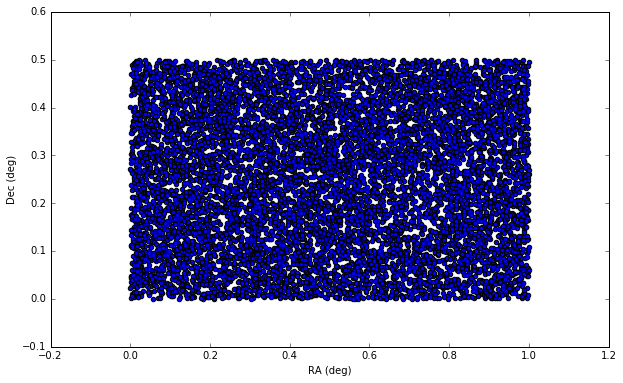

In [47]:
#Generate the randoms
ra, dec, completeness = mask_from_ranges.generate_random_sample(1e4)

#Plot
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.scatter(ra, dec)


Simple enough.  Note that if you manually change the completenesses in the ImageMask.\_mask, it will behave like ```from_array```, which is to say "not the way you expect" (this is on the list of things to be fixed).   See the next section.

### From array: Make a mask from a pre-existing array

**WARNING: This method does not work the way it should.  I have included it solely to show how the function is broken.**

The concept for this method is to make it so that an arbitrary array with elements that range from 0 to 1 can be used as an image mask.  However, at the present time, dividing the area into even bins doesn't work for reasons unbeknownst to me.  We'll make a mask from the identity matrix to illustrate the strangeness, but then show how uneven completeness works.

In [48]:
#Make the mask array
mask_array = np.identity(4)
print mask_array

#Make the ImageMask
mask_from_array = imclass.ImageMask.from_array(mask_array, [0,1], [0,1])

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
Calculating the footprint of the mask


In [49]:
%%capture
## ^ Use to suppress lengthy output

#Generate randoms
ra, dec, completeness = mask_from_array.generate_random_sample(1e4)

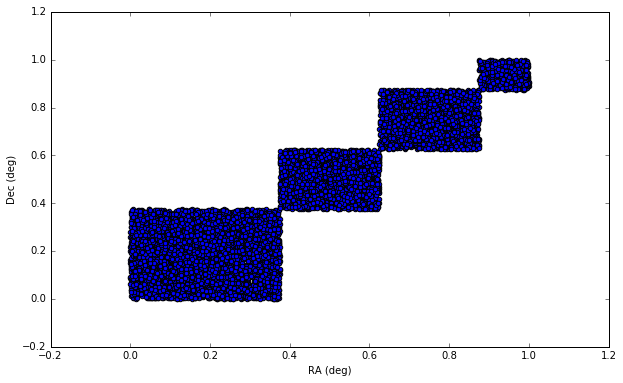

In [50]:
#Plot the randoms
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.scatter(ra, dec)

The main thing to note here is that the binning isn't even.  The mask also has a different orientation from the orientation of the array.  The origin is in the lower left, at the minimum RA and Dec.  To see this, we'll use a slightly different array to mask.

In [51]:
#Make the new array mask
mask_array2 = np.identity(4)
mask_array2[0,0] = 0.2
mask_array2[0, 3] = 0.2

print mask_array2

#Make the new mask
mask_from_array2 = imclass.ImageMask.from_array(mask_array2, [0,1], [0,1])

[[ 0.2  0.   0.   0.2]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]]
Calculating the footprint of the mask


In [52]:
%%capture
## ^ Use to suppress lengthy output

#Generate randoms
ra2, dec2, completeness = mask_from_array2.generate_random_sample(1e4)

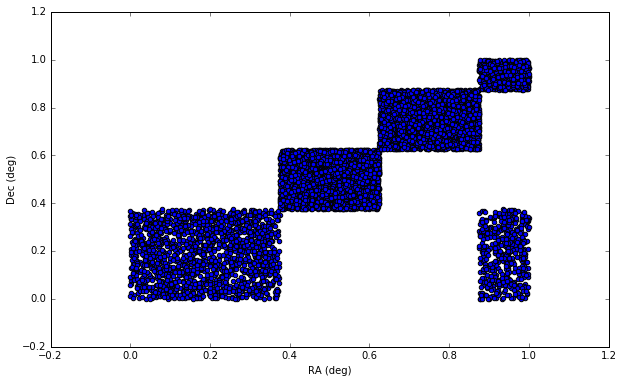

In [53]:
#Plot the randoms
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.scatter(ra2, dec2)

This clearly shows that the origin is in the lower left and also illustrates how variable completeness would be implemented in this version of Py2PAC.  Again, this should be fixed so the bins are square (or at least rectangular) in future versions.

### From FITS: Make a mask from a FITS file

**This section currently only works if you have access from your computer to the STScI central storage system.**

This function was written with the weight files from the CANDELS mosaics in mind.  In principle, it should work with any FITS image with lower values denoting lower exposure times.  The routine reads in the FITS file and finds the 5th percentile of the *nonzero* weight values from a random sample of 1e6 values on the image (to make computation time manageable).  Then, a mask is created that has completeness 1 above the 5th percentile and 0 below.  

In [54]:
#Make the mask
weight_file = '/astro/candels1/data/goodss/mosaics/current/goods_s_all_combined_v0.5/gs_all_candels_ers_udf_f160w_060mas_v0.5_wht.fits'
mask_from_fits = imclass.ImageMask.from_FITS_weight_file(weight_file)

make_mask_from_weights says: generating an image mask from a weight file


IOError: [Errno 2] No such file or directory: '/astro/candels1/data/goodss/mosaics/current/goods_s_all_combined_v0.5/gs_all_candels_ers_udf_f160w_060mas_v0.5_wht.fits'

In [ ]:
%%capture
## ^ Use to suppress lengthy output

#Generate randoms
ra, dec, completeness = mask_from_fits.generate_random_sample(1e4)

In [ ]:
#Plot the randoms
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.scatter(ra, dec)

--------

--------

## Ways to create an ```AngularCatalog```

An ```AngularCatalog``` can be created either with externally generated RAs and Decs or with randomly generated RAs and Decs.  They can have an ```ImageMask``` of any kind.  We'll start with pre-existing RAs and Decs (we'll make some up) and then move on to the ```random_catalog``` class method.


--------

### ```AngularCatalog```s from existing coordinates

For the purposes of this exercise, we'll just create a random sample of "galaxies."  For interest, we'll distribute them as a 2D Gaussian.

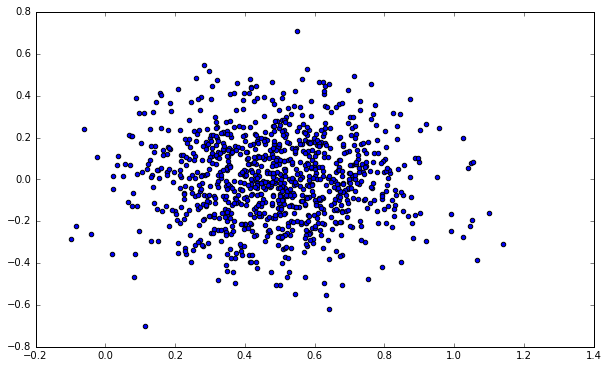

In [55]:
#Make the RAs and Decs
ras = rand.normal(loc=0.5, scale=0.2, size=int(1e3))
decs = rand.normal(loc=0, scale=0.2, size=int(1e3))
plt.scatter(ras, decs)

Now we need to make this into an ```AngularCatalog``` with some image mask.  The options are to pass an already existing ```ImageMask``` instance or to give the constructor the location of a weight file from which to construct the mask.  

#### Pre-existing ```ImageMask```

For this demonstration, we'll make a rectangular mask and pass it explicitly.

Calculating the footprint of the mask
return_completenesses says: I have 903 points that are actually on the image
return_completenesses says: I have 20000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 20000 and we need 20000.
make_randomtree says: Computing the BallTree for randoms.
showing


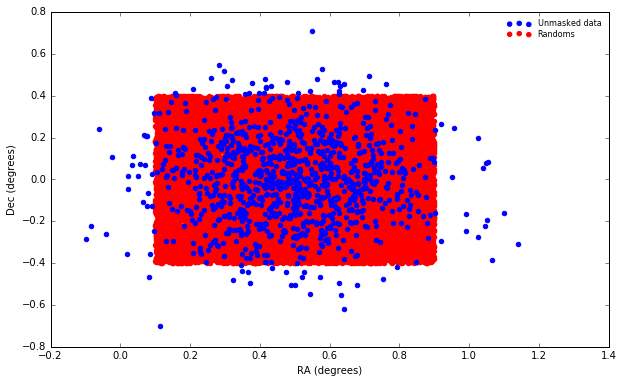

showing


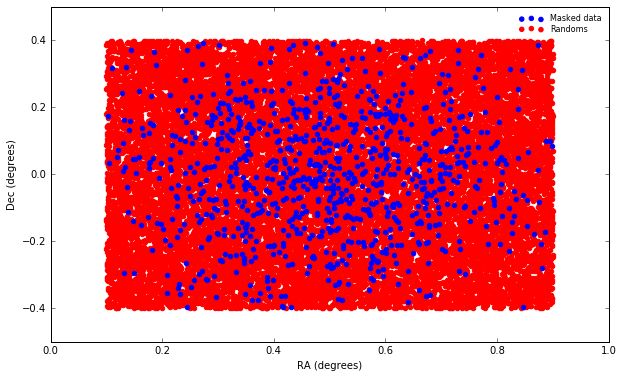

In [63]:
#Make the mask that we'll be using
immask = imclass.ImageMask.from_ranges([0.1, .9], [-0.4, 0.4])
#Make the catalog
cat = ac.AngularCatalog(ras, decs, image_mask=immask)
#Generate some randoms to showthe mask area
cat.generate_random_sample(number_to_make=2e4)

#Plot both the randoms and all the data (not just what's within the mask)
cat.scatterplot_points(sample="both", masked_data=False)
cat.scatterplot_points(sample="both", masked_data=True)

The first plot shows all the data and the second shows just the data within the mask area (just to confirm that the mask is working).


#### Creating an ```ImageMask``` from FITS at the same time you create the ```AngularCatalog```

You can also generate ```AngularCatalog```s with ```ImageMask``` from FITS files with just the constructor.  **The following section only works with access to the STScI central storage.**  For this, we need coordinates that are in the right place, so we'll just use the CANDELS galaxies.

In [ ]:
#Create an AngularCatalog with an ImageMask from a weight file
file_name = '/astro/candels1/data/goodss/mosaics/current/goods_s_all_combined_v0.5/gs_all_candels_ers_udf_f160w_060mas_v0.5_wht.fits'
gs_data = read_fits("/user/caviglia/candels_catalogs/lu_sam/march_2016/goodss0.fits")

cat_wt = ac.AngularCatalog(gs_data['ra'], gs_data['dec'], weight_file = file_name)
cat_wt.generate_random_sample(number_to_make=1e4)
cat.scatterplot_points(sample="both", masked_data=True)

--------

### ```AngularCatalog```s with randomly generated points

For testing purposes, ```AngularCatalog``` has a class method called ```random_catalog```.  This method can be called with either ranges in RA and Dec or with an existing ```ImageMask```.  The code below shows an ```AngularCatalog``` made both ways.

Calculating the footprint of the mask
return_completenesses says: I have 1000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 1000 and we need 1000.0.
return_completenesses says: I have 1000 points that are actually on the image
showing


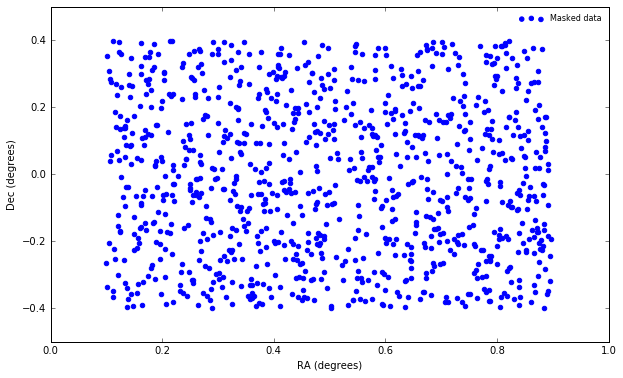

Calculating the footprint of the mask
return_completenesses says: I have 1000 points that are actually on the image
ImageMask.generate_random_sample says:  We made 1000 and we need 1000.0.
return_completenesses says: I have 1000 points that are actually on the image
showing


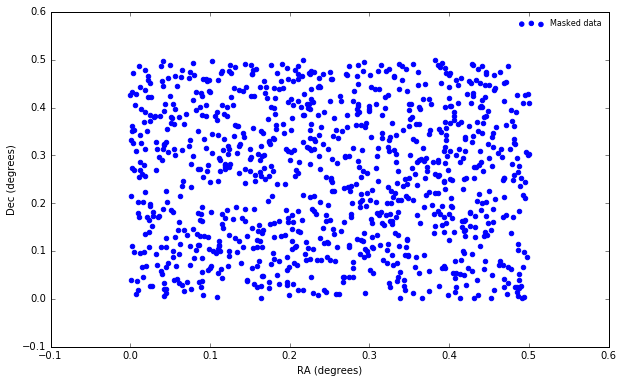

In [67]:
#Make the AngularCatalog with an existing image mask
immask = imclass.ImageMask.from_ranges([0.1, .9], [-0.4, 0.4])
rand_cat_1 = ac.AngularCatalog.random_catalog(1e3, image_mask = immask)
rand_cat_1.scatterplot_points(sample="data")

#Make the AngularCatalog over a rectangular area
rand_cat_1 = ac.AngularCatalog.random_catalog(1e3, ra_range=[0, 0.5], dec_range=[0, 0.5])
rand_cat_1.scatterplot_points(sample="data")